<center>
<h1><b>Lab 3</b></h1>
<h1>PHYS 580 - Computational Physics</h1>
<h2>Professor Molnar</h2>
</br>
<h3><b>Ethan Knox</b></h3>
<h4>https://www.github.com/ethank5149</h4>
<h4>ethank5149@gmail.com</h4>
</br>
</br>
<h3><b>September 17, 2020</b></h3>
</center>

### Imports

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

### Support Functions

In [71]:
def euler_step(f, y, t, dt):
    y = y + f(t, y) * dt
    return y


def rk2_step(f, y, t, dt):
    k1 = dt * f(t, y)
    k2 = dt * f(t + dt, y + k1)
    y = y + (k1 + k2) / 2.0
    return y


def rk4_step(f, y, t, dt):
    k1 = dt * f(t, y)
    k2 = dt * f(t + 0.5 * dt, y + 0.5 * k1)
    k3 = dt * f(t + 0.5 * dt, y + 0.5 * k2)
    k4 = dt * f(t + dt, y + k3)
    y = y + (k1 + 2.0 * (k2 + k3) + k4) / 6.0
    return 


def euler_cromer_step(f, y, dy, t, dt):
    dy = dy + f(t, y, dy) * dt
    y = y + dy * dt
    return y, dy


def dsolve(f, t, y0, step = euler_step):
    t = np.asarray(t)  # Ensure t is a Numpy array
    y0 = np.asarray(y0)

    y = np.zeros((np.size(t), np.size(y0)))  # Create our output data container
    y[0] = y0  # Set initial condition

    for i in range(np.size(t)-1):
        y[i+1] = step(f, y[i], t[i], t[i+1] - t[i])  # Step forward
    return t, y


def dsolve_simplectic(f, t, y0, dy0, step = euler_cromer_step):
    t = np.asarray(t)  # Ensure t is a Numpy array
    y0 = np.asarray(y0)

    y = np.zeros((np.size(t), np.size(y0)))  # Create our output data container
    dy = np.zeros((np.size(t), np.size(dy0)))  # Create our output data container
    y[0] = y0  # Set initial condition
    dy[0] = dy0  # Set initial condition

    for i in range(np.size(t)-1):
        y[i+1], dy[i+1] = step(f, y[i], dy[i], t[i], t[i+1] - t[i])  # Step forward

    return t, y, dy


def get_kinetic_energy(I, omega):
    return 0.5 * I * omega ** 2


def get_potential_energy(m, g, l, theta):
    return m * g * l * (1.0 - np.cos(theta))


def get_total_energy(m, I, l, g, theta, omega):
    return get_kinetic_energy(I, omega) + get_potential_energy(m, g, l, theta)


def global_error(calculated, exact):
    return np.cumsum(calculated - exact)


def local_error(y_exact, y_approx, x):
    error = np.zeros_like(x)
    for i in np.arange(1, len(error)):
        error[i-1] = y_exact(x[i]) - y_exact(x[i-1]) - (y_approx[i] - y_approx[i-1])
    return error

### Equations of Motion
<!--$$ml^2\ddot{\theta}=-k\dot{\theta}-mgl\sin(\theta)+A\cos(\omega_D t)$$-->

#### Unforced, Damped, Oscillator

$$ml^2\ddot{\theta}+c\dot{\theta}+mgl\theta=0$$
$$\ddot{\theta}+\frac{c}{ml^2}\dot{\theta}+\frac{g}{l}\theta=0$$

$$\omega_0=\sqrt{\frac{g}{l}},\,\,\zeta=\frac{c}{2m\sqrt{gl^3}}=\frac{c\omega_0^3}{2mg^2}$$

$$\ddot{\theta}+2\zeta\omega_0\dot{\theta}+\omega_0^2\theta=0$$

$$\theta_{transient}(t) = c_1e^{\left(-\sqrt{\left(\zeta^2-1\right)}-\zeta\right)\omega_0t} + c_2e^{\left(\sqrt{\left(\zeta^2-1\right)}-\zeta\right)\omega_0t}$$

$$l=\frac{g}{\omega_0^2}, \,\,m=\frac{c}{2\zeta\sqrt{gl^3}}=\frac{c\omega_0^3}{2\zeta g^2}$$

$$F=\frac{A}{ml^2}\cos(\omega_Dt)=\frac{2\zeta\omega_0A}{c}\cos(\omega_Dt)$$

$$\ddot{\theta}+2\zeta\omega_0\dot{\theta}+\omega_0^2\theta=\frac{A}{ml^2}\cos(\omega_D t)$$

$$\theta_{transient}(t) = c_1e^{-t(\sqrt{(a^2-1)b^2}+ab)} + c_2e^{t(\sqrt{(a^2-1)b^2}-ab)}$$

In [10]:
from sympy import symbols, Function, Derivative, Eq
import sympy as sp

# m, g, l, w0, wd, c, z, A, t = sp.symbols(r'm g l \omega_0 \omega_D c \zeta A t')
# theta = sp.Function(r'\theta')

# ode = sp.Eq(sp.Derivative(theta(t), t, t) + 2*z*w0*sp.Derivative(theta(t), t) + w0**2*theta(t),2*z*w0*A*sp.cos(wd*t)/c)
# ode_transient = sp.Eq(sp.Derivative(theta(t), t, t) + 2*z*w0*sp.Derivative(theta(t), t) + w0**2*theta(t),0)

# sp.dsolve(ode, theta(t))

m, g, l, wd, c, A, t = sp.symbols(r'm g l \omega_D c A t')
theta = sp.Function(r'\theta')

ode = sp.Eq(m*l**2*sp.Derivative(theta(t), t, t) + c*sp.Derivative(theta(t), t) + m*g*l*theta(t),A*sp.cos(wd*t))
ode_transient = sp.Eq(m*l**2*sp.Derivative(theta(t), t, t) + c*sp.Derivative(theta(t), t) + m*g*l*theta(t),0)

sp.dsolve(ode, theta(t))

Eq(\theta(t), -A*\omega_D**2*l**2*m*cos(\omega_D*t)/(\omega_D**2*c**2 + l**2*m**2*(\omega_D**2*l - g)**2) + A*\omega_D*c*sin(\omega_D*t)/(\omega_D**2*c**2 + l**2*m**2*(\omega_D**2*l - g)**2) + A*g*l*m*cos(\omega_D*t)/(\omega_D**2*c**2 + l**2*m**2*(\omega_D**2*l - g)**2) + C1*exp(t*(-c - sqrt(c**2 - 4*g*l**3*m**2))/(2*l**2*m)) + C2*exp(t*(-c + sqrt(c**2 - 4*g*l**3*m**2))/(2*l**2*m)))

In [72]:
def df_pendula(t, x, b, I, m, g, l, A, omega_D):
    return np.asarray([x[1], (-b * x[1] -m * g * l * np.sin(x[0]) + A * np.cos(omega_D * t)) / I])


def df_pendula_simplectic(t, x, dx, b, I, m, g, l, A, omega_D):
    return (-b * dx -m * g * l * np.sin(x) + A * np.cos(omega_D * t)) / I

# Part 1

## Parameters

In [73]:
m = 1.0
l = 1.0
I = (1.0/3.0) * m * l ** 2
b = 0.0
A = 0.1
omega_D = 0.0
g = 9.81

theta0 = np.pi / 6.0
dtheta0 = 0.0

ti = 0
tf = 25
dt = 0.001
t = np.arange(ti, tf, dt)
state0 = np.asarray([theta0, dtheta0])

## Calculate Trajectories

In [74]:
## Curried differential equation
df = partial(df_pendula, b=b, I=I, m=m, g=g, l=l, A=A, omega_D=omega_D)
df_simplectic = partial(df_pendula_simplectic, b=b, I=I, m=m, g=g, l=l, A=A, omega_D=omega_D)

## Solutions
t, vanilla_pendula_euler = dsolve(df, t, state0, step=euler_step)
t, vanilla_pendula_rk2 = dsolve(df, t, state0, step=euler_step)
t, vanilla_pendula_rk4 = dsolve(df, t, state0, step=euler_step)
t, *vanilla_pendula_euler_cromer = dsolve_simplectic(df_simplectic, t, theta0, dtheta0)

## Split up into theta and dtheta
vanilla_pendula_euler_trajectory = np.hsplit(vanilla_pendula_euler, 2)
vanilla_pendula_rk2_trajectory = np.hsplit(vanilla_pendula_rk2, 2)
vanilla_pendula_rk4_trajectory = np.hsplit(vanilla_pendula_rk4, 2)
vanilla_pendula_euler_cromer_trajectory = vanilla_pendula_euler_cromer

## Energies
vanilla_pendula_euler_energy = get_total_energy(m, I, l, g, *vanilla_pendula_euler_trajectory)
vanilla_pendula_rk2_energy = get_total_energy(m, I, l, g, *vanilla_pendula_rk2_trajectory)
vanilla_pendula_rk4_energy = get_total_energy(m, I, l, g, *vanilla_pendula_rk4_trajectory)
vanilla_pendula_euler_cromer_energy = get_total_energy(m, I, l, g, *vanilla_pendula_euler_cromer_trajectory)

## Plotting

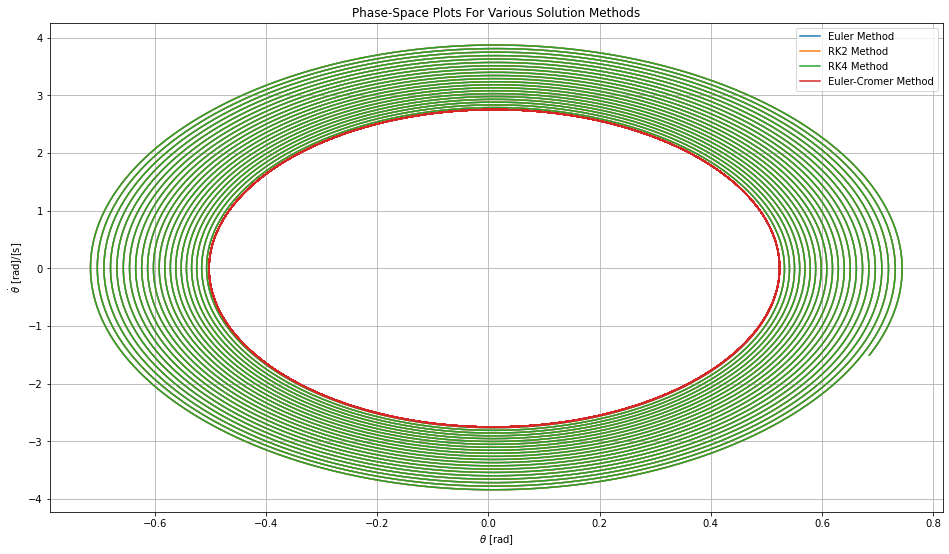

In [75]:
fig = plt.figure(figsize=(16, 9))
ax = plt.axes()

plt.plot(*vanilla_pendula_euler_trajectory, label='Euler Method')
plt.plot(*vanilla_pendula_rk2_trajectory, label='RK2 Method')
plt.plot(*vanilla_pendula_rk4_trajectory, label='RK4 Method')
plt.plot(*vanilla_pendula_euler_cromer_trajectory, label='Euler-Cromer Method')

plt.xlabel(r'$\theta$ [rad]')
plt.ylabel(r'$\dot{\theta}$ [rad]/[s]')
plt.title('Phase-Space Plots For Various Solution Methods')

plt.grid()
plt.legend()
plt.show()

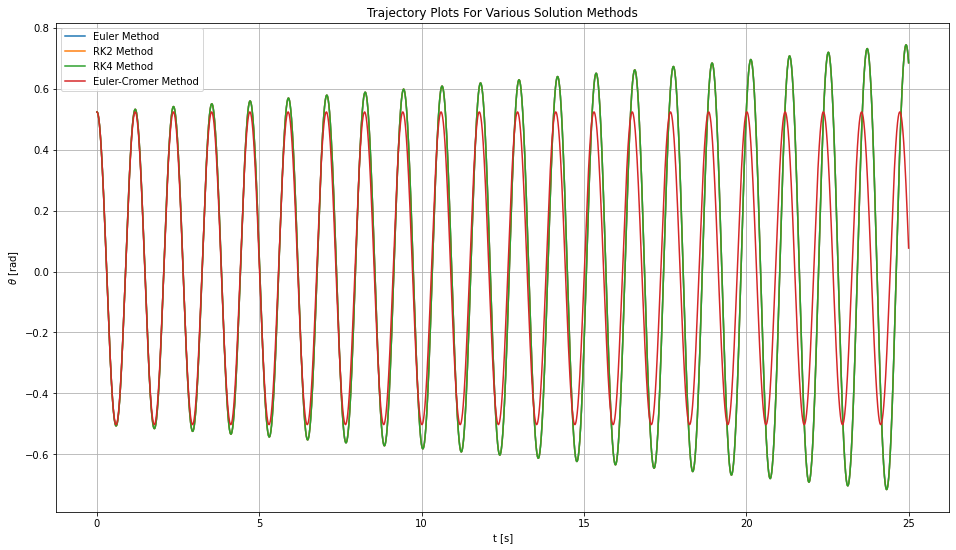

In [76]:
fig = plt.figure(figsize=(16, 9))
ax = plt.axes()

plt.plot(t, vanilla_pendula_euler_trajectory[0], label='Euler Method')
plt.plot(t, vanilla_pendula_rk2_trajectory[0], label='RK2 Method')
plt.plot(t, vanilla_pendula_rk4_trajectory[0], label='RK4 Method')
plt.plot(t, vanilla_pendula_euler_cromer_trajectory[0], label='Euler-Cromer Method')

plt.xlabel(r't [s]')
plt.ylabel(r'$\theta$ [rad]')
plt.title('Trajectory Plots For Various Solution Methods')

plt.grid()
plt.legend()
plt.show()

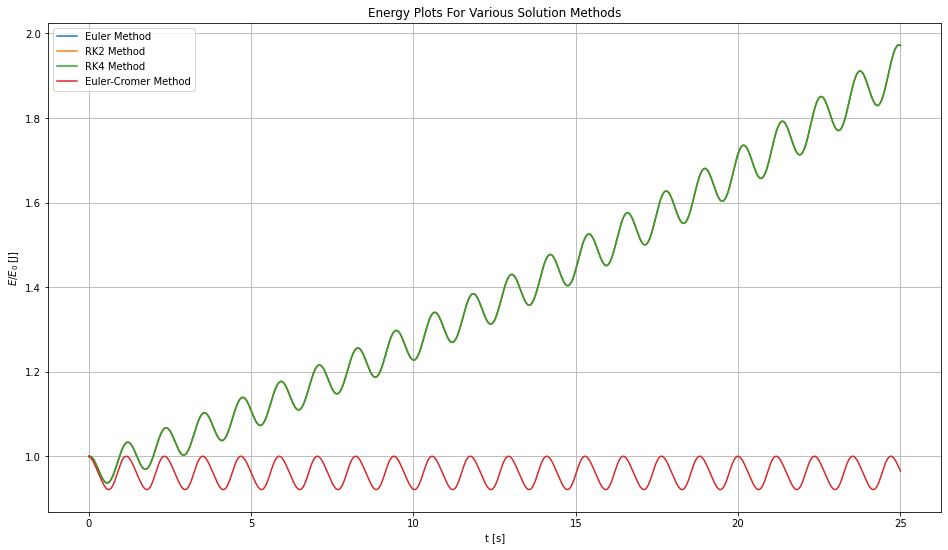

In [77]:
fig = plt.figure(figsize=(16, 9))
ax = plt.axes()

plt.plot(t, vanilla_pendula_euler_energy/vanilla_pendula_euler_energy[0], label='Euler Method')
plt.plot(t, vanilla_pendula_rk2_energy/vanilla_pendula_rk2_energy[0], label='RK2 Method')
plt.plot(t, vanilla_pendula_rk4_energy/vanilla_pendula_rk4_energy[0], label='RK4 Method')
plt.plot(t, vanilla_pendula_euler_cromer_energy/vanilla_pendula_euler_cromer_energy[0], label='Euler-Cromer Method')

plt.xlabel(r't [s]')
plt.ylabel(r'$E / E_0$ [J]')
plt.title('Energy Plots For Various Solution Methods')

plt.grid()
plt.legend()
plt.show()

# Part 2

## Parameters